In [377]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Simulate phone dataset

Text(0, 0.5, 'SEK/month')

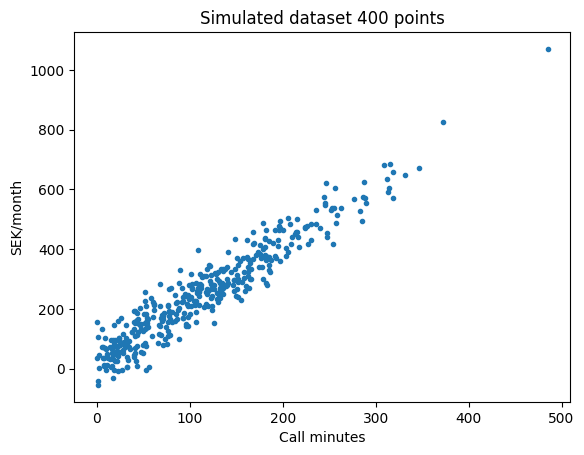

In [424]:
# a) simulate data and plot

np.random.seed(42)
samples = 400

X = abs(np.random.normal(loc=100, scale=100, size=samples))
epsilon = np.random.normal(loc=0, scale=50, size=samples)

y = 25 + 2 * X + epsilon

plt.plot(X, y, ".")
plt.title("Simulated dataset 400 points")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")


[Text(0.5, 0, 'Call minutes'),
 Text(0, 0.5, 'SEK/month'),
 Text(0.5, 1.0, 'Simulated dataseet 400 poits with boundaries')]

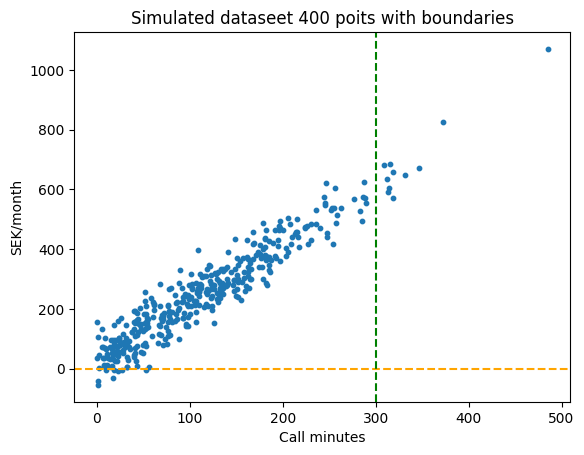

In [425]:
# a) plot simulated data with boundaries

fig, ax = plt.figure(), plt.axes()
ax.scatter(X, y, s=10)
ax.axhline(y=0, linestyle="--", color = "orange")
ax.axvline(x=300, color="green", linestyle="--")
ax.set(xlabel="Call minutes", ylabel="SEK/month", title="Simulated dataseet 400 poits with boundaries")

In [426]:
# b) remove outliers

# create touple of indexes for outliers where call minutes > 300, use to remove values from X and corresponding from y
index_X_outliers = np.where(X > 300)
X_cleaned = np.delete(X, index_X_outliers)
y_cleaned = np.delete(y, index_X_outliers)

# create touple of indexes for outliers where cost < 0, use to remove values from X and corresponding from y
index_y_outliers = np.where(y_cleaned < 0)      # look in y_cleaned in previous step
X_cleaned = np.delete(X_cleaned, index_y_outliers)
y_cleaned = np.delete(y_cleaned, index_y_outliers)

X.shape, X_cleaned.shape, y.shape, y_cleaned.shape

((400,), (381,), (400,), (381,))

In [427]:
# b) remove outliers simpler alt

filt = (X < 300) & (y > 0)

X_cleaned_filt = X[filt]
y_cleaned_filt = y[filt]

X_cleaned_filt.shape, y_cleaned_filt.shape

((381,), (381,))

In [428]:
# b) check that all outliers have been removed
np.where(X_cleaned > 300), np.where(y_cleaned < 0)

((array([], dtype=int64),), (array([], dtype=int64),))

Text(0, 0.5, 'SEK/month')

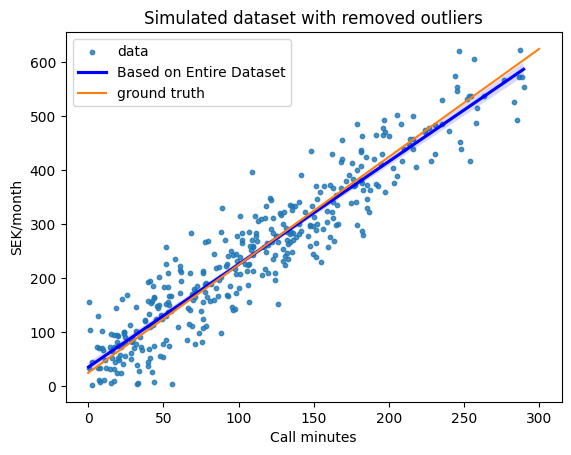

In [429]:
# b) plot ground truth and data without outliers

x = np.linspace(0, 300)
y_ground_truth = 25 + 2 * x

sns.regplot(
    x=X_cleaned,
    y=y_cleaned,
    label="data",
    line_kws={"color": "blue", "label": "Based on Entire Dataset"},
    scatter_kws={"s": 10}, 
) 
sns.lineplot(x=x, y=y_ground_truth, label="ground truth")
plt.title("Simulated dataset with removed outliers")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")


In [430]:
# X = X.reshape(400,1)
# X.T.shape, X.shape

In [431]:
# b) save values as dataframe
df = pd.DataFrame(data=(X_cleaned, y_cleaned)).T.rename(columns = {0:'call_minutes', 1:'cost'})

print(df.shape)
df.head()

(381, 2)


,call_minutes,cost
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


In [386]:
# Lösning från Andreas

df = pd.DataFrame()
df["call_minutes"] = X_cleaned
df["cost"] = y_cleaned

df.head()

,call_minutes,cost
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


---
### 1. Train|test split

In [432]:
# a) create a train|test split function

# X_train is df sincee X which is sent in is a df


def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=0.7, random_state=42, replace=False):
    """Splits dataset into training and test sets"""

    X_train = X.sample(n = int(len(X) * train_fraction), random_state=random_state, replace=replace )
    X_test = X.drop(X_train.index)

    y_train = y.sample(n = int(len(y) * train_fraction), random_state=random_state, replace=replace )
    y_test = y.drop(X_train.index)

    return (X_train, X_test, y_train, y_test)


In [433]:
# b) use train_test_split() on dataset

# funktionen kräver df eller serie in därför kan inte skicka X_train, y_train utan istället motsvarande kolumner i df där y=cost, X=call_minutes
X_train, X_test, y_train, y_test = train_test_split(df["call_minutes"], df["cost"]) 

In [434]:
# b) check if correct split by shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266,), (115,), (266,), (115,))

In [435]:
# b) check if correct split by comparing idexes
print(f"number of unitque indexes in X_train compared to X-test is {len(X_train.index.difference(X_test.index))} of expected {X_train.shape}")
print(f"number of unitque indexes in X_test compared to X-train is {len(X_test.index.difference(X_train.index))} of expected {X_test.shape}")

number of unitque indexes in X_train compared to X-test is 266 of expected (266,)
number of unitque indexes in X_test compared to X-train is 115 of expected (115,)


---
### 2. Simple linear regression with normal equation

In [436]:
# directly with polyfit
beta_1, beta_0 = np.polyfit(X_train, y_train, deg = 1) 
beta_1, beta_0

(1.9105059147861787, 32.22147721869341)

In [437]:
# with normal equation

# step 1 - add column of ones at position 0
ones = np.ones(len(X_train))
X_train_w_ones = np.c_[ones, X_train]
X_train_w_ones[:2]

array([[ 1.        , 39.97831228],
       [ 1.        , 11.61425638]])

In [438]:
# step 2 - calculate beta_hat (beta_0, beta_1) using normal equation
beta_hat = np.linalg.inv(X_train_w_ones.T @ X_train_w_ones) @ X_train_w_ones.T @ y_train
print(beta_hat)
print(f'beta_0 = {beta_hat[0]}, beta_1 = {beta_hat[1]}')

[32.22147722  1.91050591]
beta_0 = 32.2214772186932, beta_1 = 1.910505914786181


Text(0, 0.5, 'SEK/month')

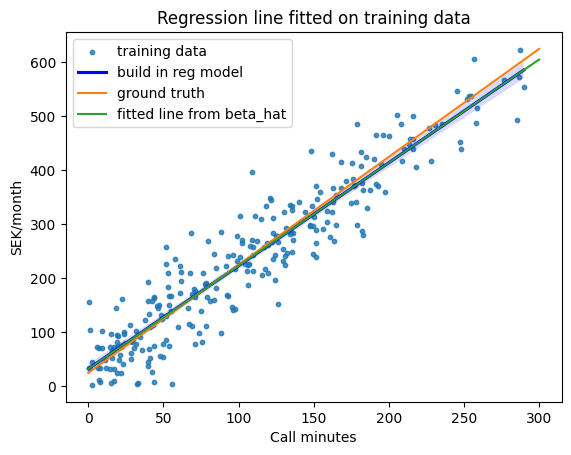

In [439]:
# step 3 - visualize

x = np.linspace(0, 300)
y_ground_truth = 25 + 2 * x
y_hat = beta_0 + beta_1 * x

# x = X_train and not X_train_w_ones
sns.regplot(
    x=X_train,
    y=y_train,
    label="training data",
    line_kws={"color": "blue", "label": "build in reg model"},
    scatter_kws={"s": 10}, 
) 
sns.lineplot(x=x, y=y_ground_truth, label="ground truth")
sns.lineplot(x=x, y=y_hat, label="fitted line from beta_hat", markers=True) # same reslut as from regplot which is expected
plt.title("Regression line fitted on training data")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")


---
### Prediction and evaluation

In [440]:
# a) predict on testing data

# add column of ones to X_test
ones = np.ones(len(X_test))
X_test_w_ones = np.c_[ones, X_test]
X_test_w_ones[:2]

array([[ 1.        , 86.17356988],
       [ 1.        , 76.58466253]])

In [442]:
# check dimensions
X_test_w_ones.shape, X_test.shape, y_test.shape, beta_hat.shape

((115, 2), (115,), (115,), (2,))

In [448]:
# create prediction function
predict = lambda x, beta: np.dot(x, beta)

# apply predict function on test data
y_pred = predict(X_test_w_ones, beta_hat) # samma som y_pred = beta_hat[0] + beta_hat[1] * X_test_w_ones
y_pred[:3], y_pred.shape

(array([196.85659218, 178.53692796, 133.57870958]), (115,))

Text(0.5, 1.0, 'Test data and regressioin line from training data')

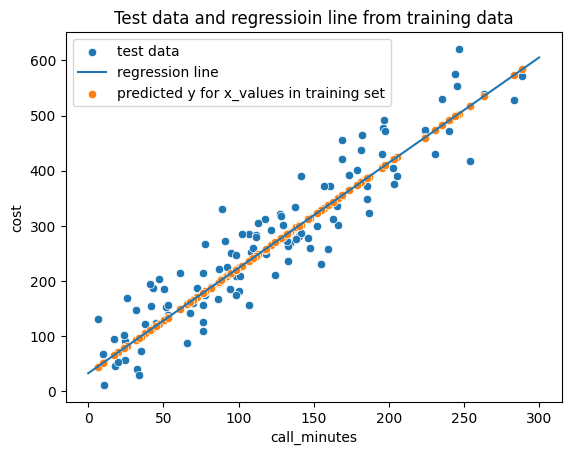

In [457]:
# visualize

x = np.linspace(0, 300)
y_hat = beta_0 + beta_1 * x

sns.scatterplot(x=X_test, y=y_test, label = "test data")
sns.lineplot(x=x, y= y_hat, label = "regression line")
sns.scatterplot(x=X_test, y=y_pred, label = "predicted y for x_values in training set")
plt.title("Test data and regressioin line from training data")

Text(0, 0.5, 'SEK/month')

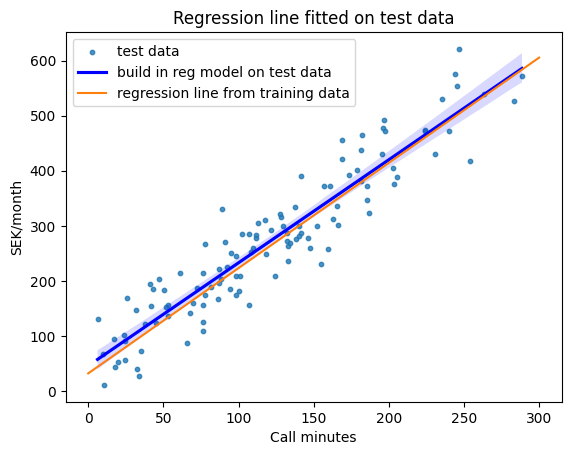

In [460]:
# regression line on testdata compared to regression line from training data
#??????????? Är det ok att visualisera så här hur regression för testdata jämförs med den beräknade regressionsmodellen från träningsdata???????

x = np.linspace(0, 300)
y_hat = beta_0 + beta_1 * x

sns.regplot(
    x=X_test,
    y=y_test,
    label="test data",
    line_kws={"color": "blue", "label": "build in reg model on test data"},
    scatter_kws={"s": 10}, 
) 
sns.lineplot(x=x, y=y_hat, label="regression line from training data", markers=True) # same reslut as from regplot which is expected
plt.title("Regression line fitted on test data")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")

In [461]:
# b) Calculate MAE, MSE, RMSE

# check dimensions
y_hat.shape, y_pred.shape

((50,), (115,))

In [469]:
# calculate

m = len(y_test)

MAE = 1/m*np.sum(np.abs(y_test-y_pred))
MSE = 1/m*np.sum((y_test-y_pred)**2)
RMSE = np.sqrt(MSE)

print(f'{MAE = :.2f}\n{MSE = :.2f}\n{RMSE = :.2f}')


MAE = 40.12
MSE = 2401.58
RMSE = 49.01
